In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import pprint
#from tqdm.auto import tqdm


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```


We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [2]:
!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv > car_price.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1440k  100 1440k    0     0  4115k      0 --:--:-- --:--:-- --:--:-- 4200k


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [3]:
columns = ["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"]

In [4]:
car_price_df = pd.read_csv("car_price.csv")[columns]
car_price_df.columns = car_price_df.columns.str.lower().str.replace(' ', '_')
car_price_df.fillna(value=0, inplace=True)

In [5]:
car_price_df.isna().any()

make                 False
model                False
year                 False
engine_hp            False
engine_cylinders     False
transmission_type    False
vehicle_style        False
highway_mpg          False
city_mpg             False
msrp                 False
dtype: bool

In [6]:
avg_price = car_price_df["msrp"].mean()
car_price_df["above_average"] = (car_price_df["msrp"] >= avg_price).astype(int)
del car_price_df["msrp"]

In [7]:
car_price_df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [8]:
car_price_df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int64
dtype: object

In [9]:
car_price_df.year = car_price_df.year.astype(object)


In [10]:
target_variable = "above_average"

categorical_features = list(car_price_df.dtypes[car_price_df.dtypes == object].index)
numerical_features = [c for c in car_price_df.columns if c not in categorical_features and c!= target_variable]
print(f"categorical_features = {categorical_features}")
print(f"numerical_features = {numerical_features}")

categorical_features = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']
numerical_features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']


In [11]:
df = {}

df["full_train"], df["test"] = train_test_split(car_price_df, test_size=0.2, random_state=1)
df["train"], df["val"] = train_test_split(df["full_train"], test_size=0.25, random_state=1) # 0.8 * ? = 0.2 => ? = 0.2/0.8 = 0.25


def prepare_data(df, target_variable, label, data):
    df = df.reset_index(drop=True)
    data[label]["y"] = df[target_variable].to_numpy()
    del df[target_variable]
    data[label]["X"] = df


labels = ["train", "val", "test", "full_train"]
data = {label: {} for label in labels}
target_variable = "above_average"
for label in labels:
    prepare_data(df[label], target_variable, label, data)

In [12]:
for label in labels:
    for v in ["X", "y"]:
        print(f"{label} data : {v} is of shape = {data[label][v].shape}")

train data : X is of shape = (7148, 9)
train data : y is of shape = (7148,)
val data : X is of shape = (2383, 9)
val data : y is of shape = (2383,)
test data : X is of shape = (2383, 9)
test data : y is of shape = (2383,)
full_train data : X is of shape = (9531, 9)
full_train data : y is of shape = (9531,)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`


In [13]:
def plot_roc_for_numerical_feature(fpr, tpr, feature_name, auc_value):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"{feature_name} [AUC] = {auc_value}")
    plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    
def compute_auc_for_numerical_feature(df, y, feature_name):
    X = df[feature_name]
    fpr, tpr, thresholds = roc_curve(y, X)
    auc_value = auc(fpr, tpr)
    if auc_value < 0.5:
        new_fpr, new_tpr, thresholds = roc_curve(y, -X)
        auc_value = auc(new_fpr, new_tpr)

    auc_value = round(auc_value, 4)
    plot_roc_for_numerical_feature(fpr, tpr, feature_name, auc_value)

    return auc_value
        
        
        


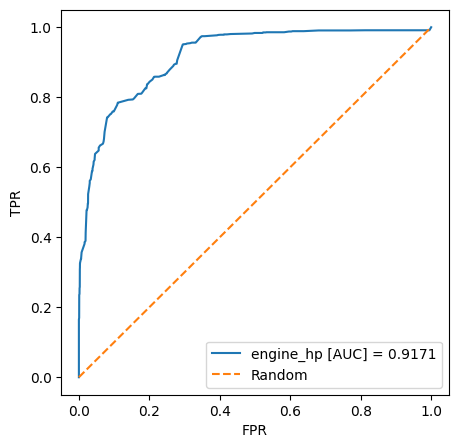

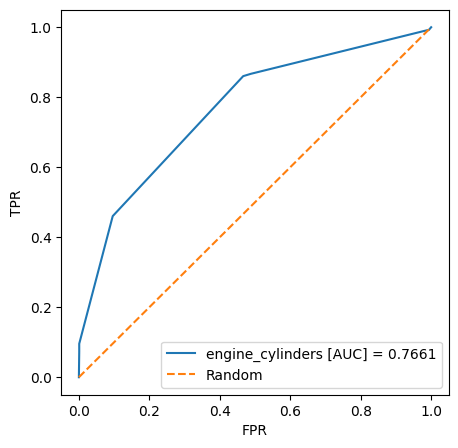

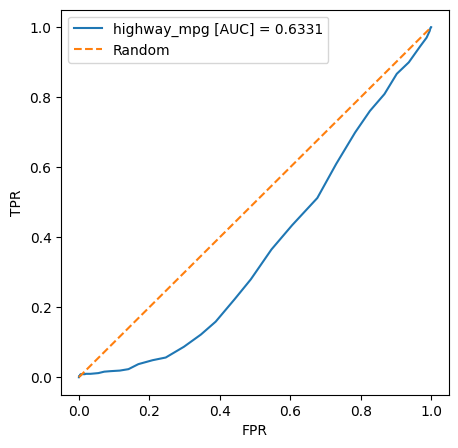

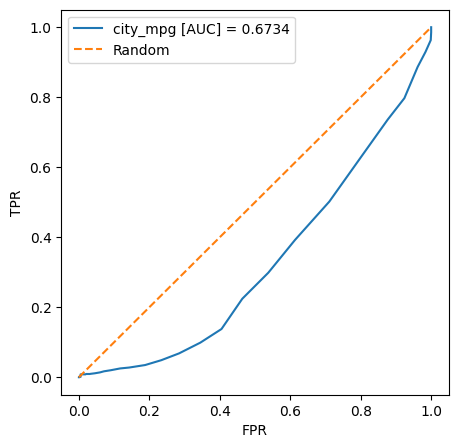

In [14]:
auc_values = {}
for feature in numerical_features:
    auc_val = compute_auc_for_numerical_feature(data["train"]["X"], data["train"]["y"], feature)
    auc_values[feature] = auc_val

In [15]:
pprint.pprint(auc_values)
print(f"feature with max auc = {max(auc_values, key = lambda x: auc_values[x])}")

{'city_mpg': 0.6734,
 'engine_cylinders': 0.7661,
 'engine_hp': 0.9171,
 'highway_mpg': 0.6331}
feature with max auc = engine_hp


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [16]:
dv = DictVectorizer(sparse=False)
train_dict = data["train"]["X"].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

In [17]:
train_dict[:2]

[{'make': 'Toyota',
  'model': 'Highlander Hybrid',
  'year': 2016,
  'engine_hp': 280.0,
  'engine_cylinders': 6.0,
  'transmission_type': 'AUTOMATIC',
  'vehicle_style': '4dr SUV',
  'highway_mpg': 28,
  'city_mpg': 27},
 {'make': 'Chevrolet',
  'model': 'Impala Limited',
  'year': 2014,
  'engine_hp': 300.0,
  'engine_cylinders': 6.0,
  'transmission_type': 'AUTOMATIC',
  'vehicle_style': 'Sedan',
  'highway_mpg': 30,
  'city_mpg': 18}]

In [18]:
X_train[0:2,:]

array([[2.700e+01, 6.000e+00, 2.800e+02, ..., 0.000e+00, 0.000e+00,
        2.016e+03],
       [1.800e+01, 6.000e+00, 3.000e+02, ..., 1.000e+00, 0.000e+00,
        2.014e+03]])

In [19]:
dv.inverse_transform(X_train[0:2,:])

[{'city_mpg': 27.0,
  'engine_cylinders': 6.0,
  'engine_hp': 280.0,
  'highway_mpg': 28.0,
  'make=Toyota': 1.0,
  'model=Highlander Hybrid': 1.0,
  'transmission_type=AUTOMATIC': 1.0,
  'vehicle_style=4dr SUV': 1.0,
  'year': 2016.0},
 {'city_mpg': 18.0,
  'engine_cylinders': 6.0,
  'engine_hp': 300.0,
  'highway_mpg': 30.0,
  'make=Chevrolet': 1.0,
  'model=Impala Limited': 1.0,
  'transmission_type=AUTOMATIC': 1.0,
  'vehicle_style=Sedan': 1.0,
  'year': 2014.0}]

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, data["train"]["y"])

LogisticRegression(max_iter=1000, solver='liblinear')

In [21]:
val_dict = data["val"]["X"].to_dict(orient="records")
X_val = dv.transform(val_dict)
y_pred_prob = model.predict_proba(X_val)[:, 1]

In [22]:
fpr, tpr, thresholds = roc_curve(data["val"]["y"], y_pred_prob)
auc_value = auc(fpr, tpr)
print(round(auc_value,3))

0.979


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [23]:
thresholds = np.linspace(0, 1, 101)


precision_scores = []
recall_scores = []



for t in thresholds:
    #y_pred_prob = model.predict_proba(X_val)[:, 1] >= t
    precision_scores.append(precision_score(data["val"]["y"], y_pred_prob >= t, zero_division = 0))
    recall_scores.append(recall_score(data["val"]["y"], y_pred_prob >= t, zero_division=0))

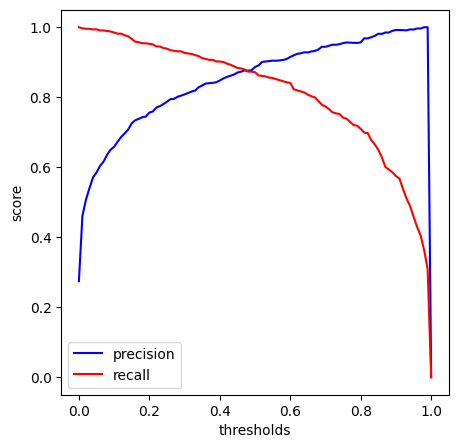

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(thresholds, precision_scores, label=f"precision", color="blue")
plt.plot(thresholds, recall_scores, label=f"recall", color="red")
plt.xlabel('thresholds')
plt.ylabel('score')
plt.legend();

In [25]:
[(p, r, t) for (p,r,t) in zip(precision_scores, recall_scores, thresholds) if round(p,2) == round(r,2)]

[(0.8765243902439024, 0.8792048929663608, 0.47000000000000003),
 (0.0, 0.0, 1.0)]

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [26]:
p = np.array(precision_scores)
r = np.array(recall_scores)
#f1_scores = 2*p*r/(p+r)
f1_scores = np.divide(2*p*r, p+r, out=np.zeros_like(2*p*r), where=p+r!=0)

In [27]:
f1_scores

array([0.43068818, 0.63056093, 0.67182663, 0.70037655, 0.72504183,
       0.73654391, 0.75043428, 0.75967175, 0.77392344, 0.78398058,
       0.78921569, 0.79850746, 0.80805538, 0.81349459, 0.81981982,
       0.82885246, 0.83156499, 0.83355526, 0.83534137, 0.83646113,
       0.84303112, 0.84453496, 0.8489011 , 0.85123967, 0.85298197,
       0.85634589, 0.85874912, 0.85855032, 0.86138614, 0.86321758,
       0.86324786, 0.8649035 , 0.86657102, 0.86681066, 0.87082729,
       0.87070855, 0.8730741 , 0.87205882, 0.87270052, 0.87149188,
       0.87407407, 0.8764881 , 0.87658938, 0.87687688, 0.87631976,
       0.87708649, 0.87756654, 0.8778626 , 0.87442573, 0.87509579,
       0.87895143, 0.87645688, 0.88037529, 0.88018794, 0.87912088,
       0.87893082, 0.87716535, 0.87608524, 0.875     , 0.87460317,
       0.87649402, 0.86844229, 0.86871961, 0.86758733, 0.86715566,
       0.86345053, 0.86206897, 0.86090535, 0.85643154, 0.85331098,
       0.85042017, 0.84699915, 0.84255319, 0.84057971, 0.84030

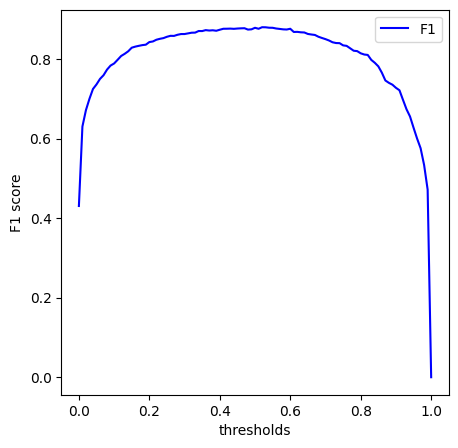

In [28]:
plt.figure(figsize=(5, 5))
plt.plot(thresholds, f1_scores, label=f"F1", color="blue")
plt.xlabel('thresholds')
plt.ylabel('F1 score')
plt.legend();

In [29]:
thresholds[np.argmax(f1_scores)]

0.52

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [30]:
def train(df, y, C):
    dv = DictVectorizer(sparse=False)
    train_dict = df.to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)
    return dv, model

def predict(df, dv, model):
    data_dict = df.to_dict(orient="records")
    X = dv.transform(data_dict)
    y_pred_prob = model.predict_proba(X)[:, 1]
    return y_pred_prob

def get_auc_score(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    auc_score = auc(fpr, tpr)
    return round(auc_score,3)

In [31]:
def get_auc_scores_across_folds(n_splits, C):
    auc_scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(data["full_train"]["X"]):
        df_train = data["full_train"]["X"].iloc[train_idx]
        df_val = data["full_train"]["X"].iloc[val_idx]
    
        #print(len(train_idx), len(val_idx))
        #print(df_train.shape, df_val.shape)
        
        y_train = data["full_train"]["y"][train_idx]
        y_val = data["full_train"]["y"][val_idx]
    
        #print(y_train.shape, y_val.shape)
    
        dv, model = train(df_train, y_train, C)
        y_pred_prob = predict(df_val, dv, model)
        auc_score = get_auc_score(y_val, y_pred_prob)
        auc_scores.append(auc_score)
    return auc_scores

In [32]:
auc_scores = get_auc_scores_across_folds(n_splits=5, C=1.0)
print(f"AUC scores across folds = {auc_scores}")
print(f"standard deviation of AUC scores across folds = {round(np.std(auc_scores),3)}")

AUC scores across folds = [0.978, 0.98, 0.978, 0.98, 0.986]
standard deviation of AUC scores across folds = 0.003











### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.




In [ ]:
hyperparameter_scores = {}
for C in [0.01, 0.1, 0.5, 10]:
    auc_scores = np.array(get_auc_scores_across_folds(n_splits=5, C=C))
    hyperparameter_scores[C] = {"mean": round(auc_scores.mean(),3), "std": round(np.std(auc_scores),3), "raw": auc_scores}

pprint.pprint(hyperparameter_scores)
    

In [ ]:
max(hyperparameter_scores, key = lambda C: (hyperparameter_scores[C]["mean"], -hyperparameter_scores[C]["std"], -C))